In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import pyodbc
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
server = 'DB06.petvetcarecenters.com' 
database = 'ReportingPV' 
username = 'PetVet_RW' 
password = 'p3tv3tc@r3c3nt3rs'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [4]:
server = 'DB04.petvetcarecenters.com' 
database = 'DWPV' 
username = 'PetVet_RW' 
password = 'p3tv3tc@r3c3nt3rs'  
conn_str = (
    'DRIVER={SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)
# Establish the connection
conn = pyodbc.connect(conn_str)
query = """
SELECT DISTINCT 
    s.Description SkuDescription,
  dm.Name AS MasterClassification  --m.ChangeBy,
  --m.ChangeDate   
FROM (
  SELECT *
  FROM Configuration.SkuMapping
  WHERE DropDownListId = 8
) m
JOIN Accounting.SkuV2 s
  ON s.Location_ID = m.Location_ID
  AND s.Sku = m.Sku
JOIN Reference.DropdownListMember dm
  ON dm.DropdownListMemberId = m.DropdownListMemberId
"""
# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, conn)


# Close the connection
conn.close()


C:\Users\qallegue\AppData\Local\Temp\ipykernel_4428\2213194863.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
train = df

In [6]:
train.head()

,SkuDescription,MasterClassification
0,$20.00 off Simparica Trio 6ct Exp 12/31,Preventative
1,$25 First-Time Visit Offer,Exam
2,$25 New Pet/Client Exam,Exam
3,(b) 61-90mins,Anesthesia
4,(BR2LT) Bravecto $15 Instant Rebate 2 doses,Preventative


In [7]:
train.dropna(subset=['SkuDescription'], inplace= True) # Prefiction relies on SkuDescription

<Axes: >

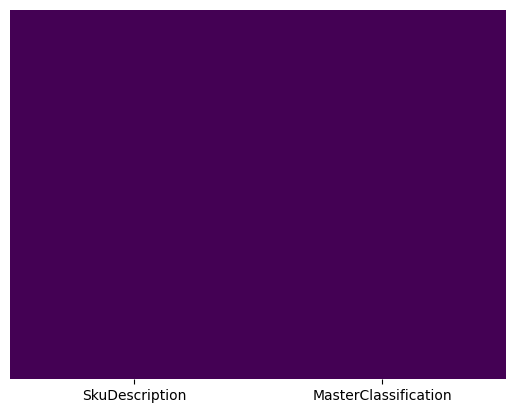

In [8]:
## No more missing data
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = "viridis")

In [100]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import nltk

In [10]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


        C:\Users\qallegue\AppData\Roaming\nltk_data...
      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


In [11]:
desc = [line.strip() for line in train['SkuDescription']]

In [13]:
train.describe()

,SkuDescription,MasterClassification
count,31831,31831
unique,31775,26
top,Fine Needle Aspirate,Preventative
freq,3,11806


In [14]:
train.groupby('MasterClassification').describe()

SkuDescription         \
                                 count unique   
MasterClassification                            
Anesthesia                         898    898   
Boarding-Grooming                  796    796   
Cremation                          543    543   
Dentistry                          915    915   
Disc-Coup-Promo-Refund               1      1   
Euthanasia                         289    289   
Exam                              1500   1500   
Farm Call                           23     23   
Food                               121    121   
Hospitalization                    734    734   
Injection                         1983   1983   
Lab                               1154   1154   
Lab-Inside                        1088   1088   
Lab-Outside                       2042   2042   
Medical-Waste                      180    180   
Medication                        1990   1990   
OTC                                 59     59   
Preventative                     11806  11806   
Procedure                          616    616   
Radiology                         1042   1042   
Spay-Neuter                        697    697   
Surgery                            602    602   
Ultrasound-Imaging                 176    176   
Unspecified                        105    105   
Vaccine                           2368   2368   
Well Plans and Packages            103    103   

                                                                        
                                                              top freq  
MasterClassification                                                    
Anesthesia                                          (b) 61-90mins    1  
Boarding-Grooming                                     ABBEY GROOM    1  
Cremation                                 AMS-ROSEWOOD URN 10-39#    1  
Dentistry                          [Feline Dental Grade 2 Package    1  
Disc-Coup-Promo-Refund                     $25.00 off First Exam     1  
Euthanasia                                  1 Euthanasia - BUNDLE    1  
Exam                                   $25 First-Time Visit Offer    1  
Farm Call                                Emergency Call (8AM-6PM)    1  
Food                               10044 C Metabolic+Mobility 24#    1  
Hospitalization                 30mg Vial (CAD Immunotherapeutic)    1  
Injection                       40mg Vial (CAD Immunotherapeutic)    1  
Lab                                   8659999 SENIOR SCREEN -SICK    1  
Lab-Inside                                    4Dx Plus Snap Test     1  
Lab-Outside                            2801 Idexx Cytology 1 Site    1  
Medical-Waste                              Biohazard Disposal Fee    1  
Medication               Administer Claro Ear Treatment - Per Ear    1  
OTC                                 Advita Probiotics 30ct Canine    1  
Preventative              $20.00 off Simparica Trio 6ct Exp 12/31    1  
Procedure                                   A/G Expression - Tech    1  
Radiology                   3 X-Ray view without Rad.Consultation    1  
Spay-Neuter                                    Alter:canine   <45    1  
Surgery                   *Cranial Cruciate Surgery ( over 50 # )    1  
Ultrasound-Imaging             Abdom Ultrasound Companion Insight    1  
Unspecified                *WRITE IN  RX - LABEL PRINT/ADD TO RXS    1  
Vaccine                           1 Year Kennel Cough Vaccination    1  
Well Plans and Packages              *Puppy Package 3 (1st Visit)    1

In [15]:
train['length'] = train['SkuDescription'].apply(len)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
%matplotlib inline

<Axes: ylabel='Frequency'>

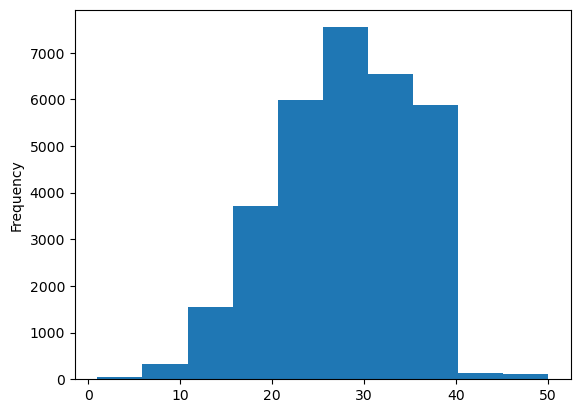

In [22]:
train['length'].plot.hist(bins=10)

array([[<Axes: title={'center': 'Anesthesia'}>,
        <Axes: title={'center': 'Boarding-Grooming'}>,
        <Axes: title={'center': 'Cremation'}>,
        <Axes: title={'center': 'Dentistry'}>,
        <Axes: title={'center': 'Disc-Coup-Promo-Refund'}>],
       [<Axes: title={'center': 'Euthanasia'}>,
        <Axes: title={'center': 'Exam'}>,
        <Axes: title={'center': 'Farm Call'}>,
        <Axes: title={'center': 'Food'}>,
        <Axes: title={'center': 'Hospitalization'}>],
       [<Axes: title={'center': 'Injection'}>,
        <Axes: title={'center': 'Lab'}>,
        <Axes: title={'center': 'Lab-Inside'}>,
        <Axes: title={'center': 'Lab-Outside'}>,
        <Axes: title={'center': 'Medical-Waste'}>],
       [<Axes: title={'center': 'Medication'}>,
        <Axes: title={'center': 'OTC'}>,
        <Axes: title={'center': 'Preventative'}>,
        <Axes: title={'center': 'Procedure'}>,
        <Axes: title={'center': 'Radiology'}>],
       [<Axes: title={'center': 'Spay-

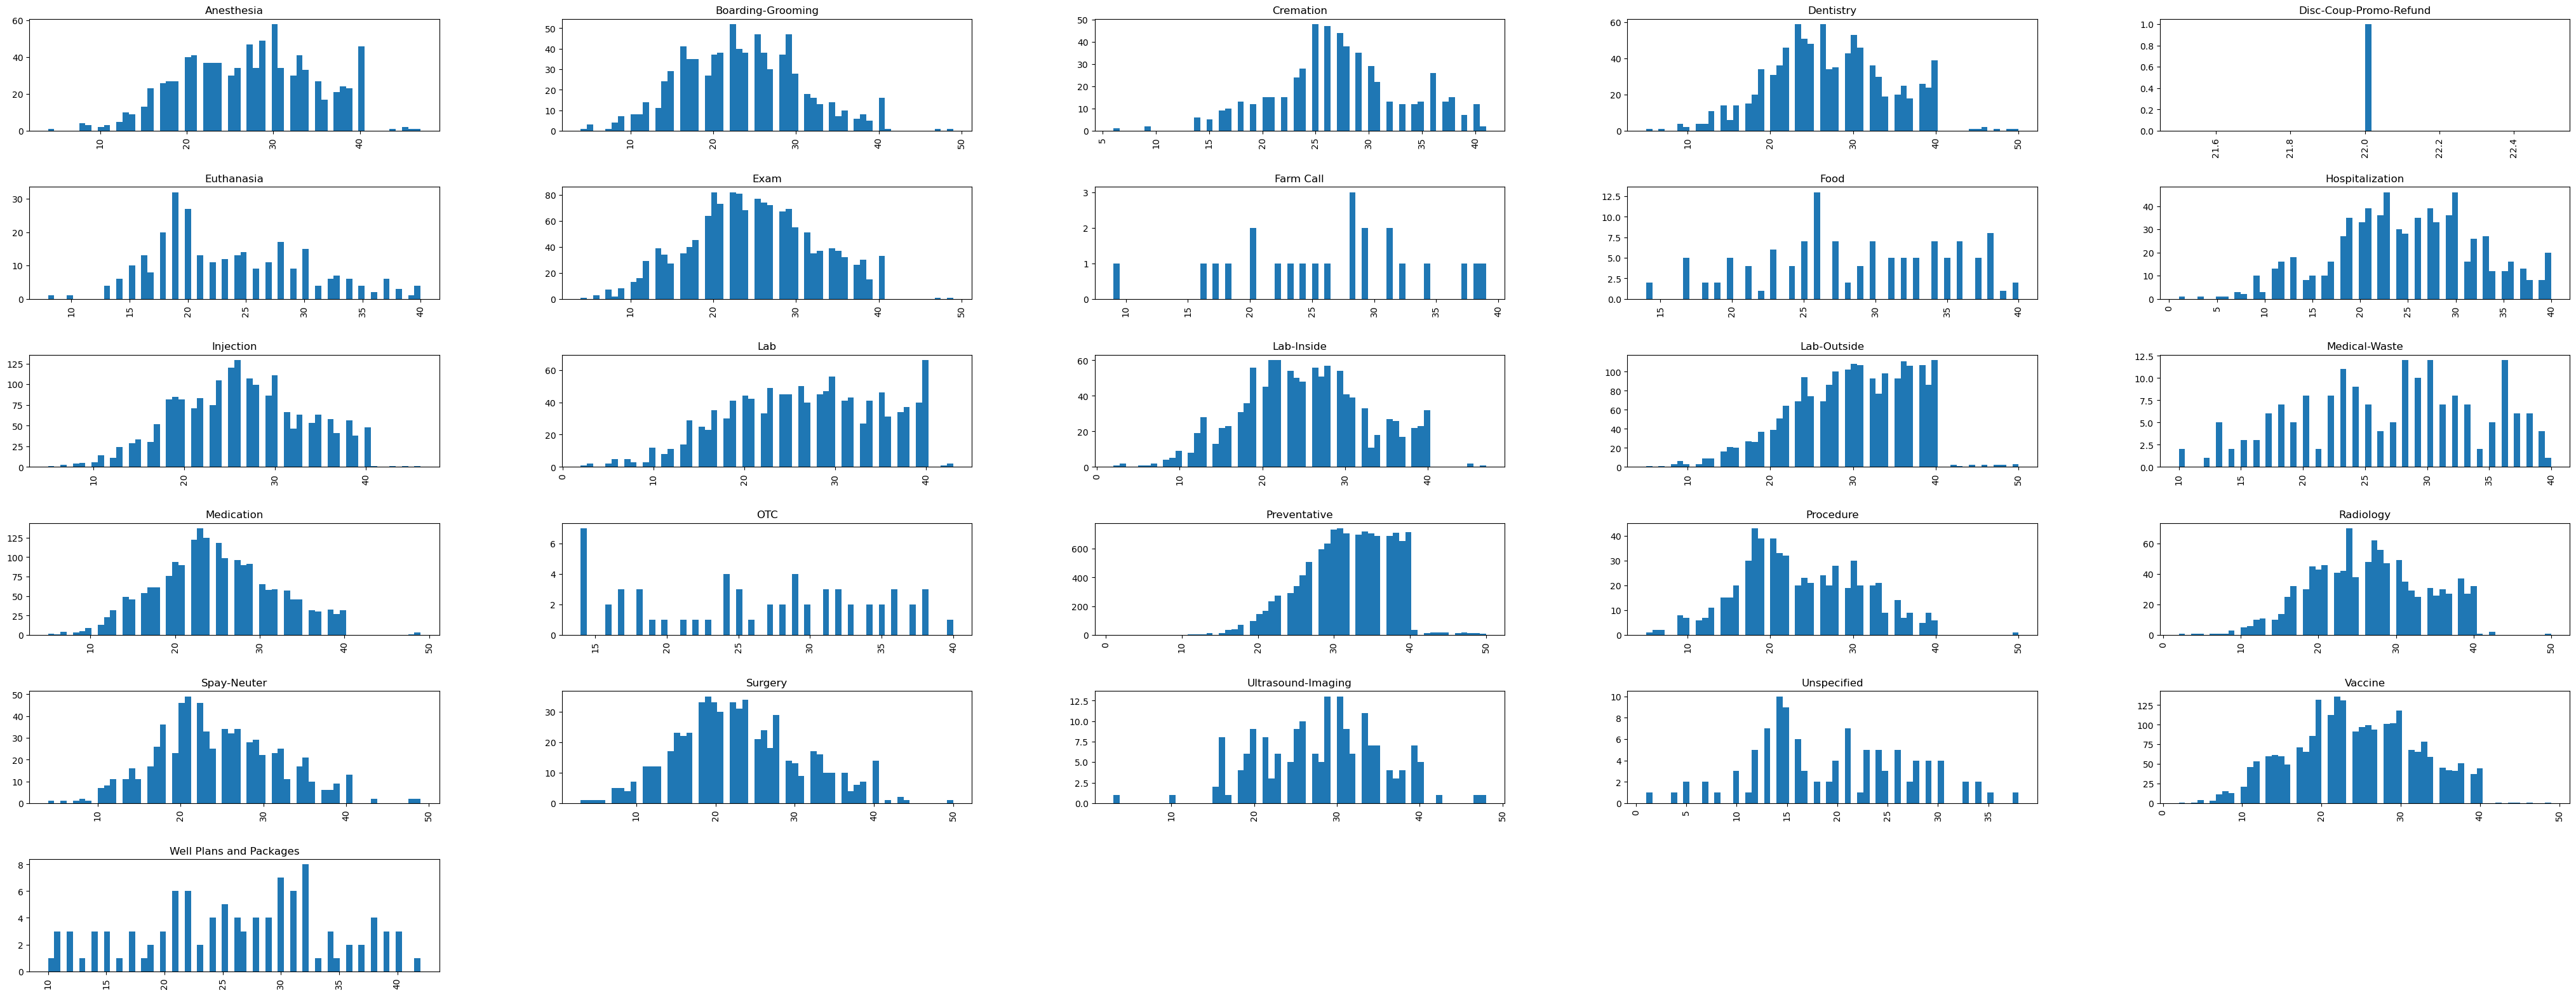

In [25]:
train.hist(column = 'length', by = 'MasterClassification', bins = 60, figsize=(50, 20))

In [26]:
import string

In [29]:
from nltk.corpus import stopwords

In [31]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)

    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [32]:
train.head()

,SkuDescription,MasterClassification,length
0,$20.00 off Simparica Trio 6ct Exp 12/31,Preventative,39
1,$25 First-Time Visit Offer,Exam,26
2,$25 New Pet/Client Exam,Exam,23
3,(b) 61-90mins,Anesthesia,13
4,(BR2LT) Bravecto $15 Instant Rebate 2 doses,Preventative,43


In [34]:
train['SkuDescription'].head(5).apply(text_process)

0             [2000, Simparica, Trio, 6ct, Exp, 1231]
1                       [25, FirstTime, Visit, Offer]
2                          [25, New, PetClient, Exam]
3                                       [b, 6190mins]
4    [BR2LT, Bravecto, 15, Instant, Rebate, 2, doses]
Name: SkuDescription, dtype: object

## Vectorization
### CountVectorizer: a 2D matrix where 
- the first dimension is the entire vocabulary (i.e. 1 col per word);
- the second dimension is the actual documents (i.e. 1 row per sku descripition)
- output: sparse matrix:
  - (rownum, colnum)    wordcount
  - see print(desc_bow)

In [108]:
train = train[train['MasterClassification'] !='Disc-Coup-Promo-Refund']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [160]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train['SkuDescription'])

In [161]:
print(len(bow_transformer.vocabulary_))

11548


In [162]:
print(train['SkuDescription'][2000])

Anesthesia Isoflurane Dental 51-99


In [163]:
eg = bow_transformer.transform([train['SkuDescription'][2000]])

In [164]:
print(eg.shape)
print(eg)

(1, 11548)
  (0, 2045)	1
  (0, 3095)	1
  (0, 4732)	1
  (0, 6434)	1


In [195]:
bow_transformer.get_feature_names_out()[4732]

'Dental'

In [166]:
desc_bow = bow_transformer.transform(train['SkuDescription'])

In [215]:
print(desc_bow)

  (0, 437)	1
  (0, 828)	1
  (0, 2407)	1
  (0, 5296)	1
  (0, 8956)	1
  (0, 9553)	1
  (1, 1073)	1
  (1, 5577)	1
  (1, 7346)	1
  (1, 9852)	1
  (2, 1073)	1
  (2, 5234)	1
  (2, 7199)	1
  (2, 7799)	1
  (3, 2300)	1
  (3, 10255)	1
  (4, 593)	1
  (4, 825)	1
  (4, 3306)	1
  (4, 3507)	1
  (4, 6375)	1
  (4, 8327)	1
  (4, 10457)	1
  (5, 593)	1
  (5, 2434)	1
  :	:
  (31823, 10171)	1
  (31824, 674)	1
  (31824, 11527)	1
  (31825, 10249)	1
  (31825, 11533)	1
  (31826, 2101)	1
  (31826, 2185)	1
  (31826, 7846)	1
  (31826, 10172)	1
  (31826, 10285)	1
  (31827, 172)	1
  (31827, 4599)	1
  (31827, 9646)	1
  (31827, 10097)	1
  (31827, 11534)	1
  (31828, 1019)	1
  (31828, 7801)	1
  (31828, 11138)	1
  (31828, 11538)	1
  (31829, 398)	1
  (31829, 6773)	1
  (31829, 10363)	1
  (31829, 10954)	1
  (31829, 11153)	1
  (31829, 11543)	1


In [168]:
print(desc_bow.shape) #shape of sparse matrix: 31,830 sku description, 11,548 total vocab

(31830, 11548)


In [169]:
desc_bow.nnz

128687

In [217]:
##calculates the percentage of non-0 entries
sparsity = (100.0 * desc_bow.nnz / (desc_bow.shape[0] * desc_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

sparsity: 0.035009931636951194


## Build model

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer

In [171]:
tfidf_transformer = TfidfTransformer().fit(desc_bow)

In [174]:
desc_tfidf = tfidf_transformer.transform(desc_bow)

In [218]:
print(desc_tfidf)

  (0, 437)	0.5369569656662905
  (0, 828)	0.5369569656662905
  (0, 2407)	0.3197780265534686
  (0, 5296)	0.47951476146545663
  (0, 8956)	0.1992753374007726
  (0, 9553)	0.22682896909125988
  (1, 1073)	0.35112385830245335
  (1, 5577)	0.6320629321777651
  (1, 7346)	0.5807141058671602
  (1, 9852)	0.3741384946040024
  (2, 1073)	0.3851099072351374
  (2, 5234)	0.33297846038368184
  (2, 7199)	0.48180002639749697
  (2, 7799)	0.7132211710495054
  (3, 2300)	0.7443717489316507
  (3, 10255)	0.667765452380127
  (4, 593)	0.35062144295104375
  (4, 825)	0.30104111130197875
  (4, 3306)	0.6206455559588643
  (4, 3507)	0.2389831025016575
  (4, 6375)	0.3403951889105008
  (4, 8327)	0.3067972759575599
  (4, 10457)	0.36623977182686945
  (5, 593)	0.3472837177674309
  (5, 2434)	0.2871475380687843
  :	:
  (31823, 10171)	0.5552660229303491
  (31824, 674)	0.5533398179333836
  (31824, 11527)	0.8329556085947498
  (31825, 10249)	0.6829953026064458
  (31825, 11533)	0.7304227656758306
  (31826, 2101)	0.37503609425790146
 

In [156]:
from sklearn.ensemble import RandomForestClassifier

In [212]:
## pass in desc_tfidf as features
master_classification_model = RandomForestClassifier().fit(desc_tfidf, train['MasterClassification'])

## Test out the model on individual datapoints

In [204]:
bow2000 = bow_transformer.transform([train['SkuDescription'][2000]])

In [205]:
print(bow2000)

  (0, 2045)	1
  (0, 3095)	1
  (0, 4732)	1
  (0, 6434)	1


In [206]:
tfidf2000 = tfidf_transformer.transform(bow2000)

In [213]:
## from simple word count => weighted tf-idf scores
print(tfidf2000)

  (0, 2045)	0.7052029640444519
  (0, 3095)	0.37950381047803455
  (0, 4732)	0.35722966688431607
  (0, 6434)	0.4806793135067206


In [209]:
print(bow_transformer.vocabulary_['Anesthesia'])

3095


In [211]:
## check the idf of a particular word
tfidf_transformer.idf_[bow_transformer.vocabulary_['Anesthesia']]

5.37174384806591

In [191]:
master_classification_model.predict(tfidf2000)[0]

'Anesthesia'

In [190]:
train['MasterClassification'][2000]

'Anesthesia'

## Pipeline

In [88]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [79]:
from sklearn.model_selection import train_test_split

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', CalibratedClassifierCV(LinearSVC(dual=False)))
])

## Support Vector Machine model
### Performs better than Random Forest

In [238]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
     ('tfidf', TfidfTransformer()),
     ('classifier', CalibratedClassifierCV(LinearSVC(dual=False)))   
     ])


In [229]:
pipeline_RF = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
     ('tfidf', TfidfTransformer()),
     ('classifier', RandomForestClassifier())   
     ])


In [126]:
X_train, X_test, y_train, y_test = train_test_split(train['SkuDescription'], train['MasterClassification'], test_size = 0.2)

In [240]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002A4BEAB1440>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 CalibratedClassifierCV(estimator=LinearSVC(dual=False)))])

In [241]:
# Predict
predictions = pipeline.predict(X_test)

In [242]:
probability_scores = pipeline.predict_proba(X_test)

In [247]:
from sklearn.metrics import classification_report, confusion_matrix

# Overall metrics
print(classification_report(y_test, predictions))

# Detailed per-class view
conf_matrix = confusion_matrix(y_test, predictions)

                         precision    recall  f1-score   support

             Anesthesia       0.90      0.86      0.88       188
      Boarding-Grooming       0.96      0.95      0.95       180
              Cremation       0.93      0.92      0.93       102
              Dentistry       0.97      0.95      0.96       189
             Euthanasia       0.95      0.86      0.90        63
                   Exam       0.88      0.90      0.89       284
              Farm Call       1.00      0.71      0.83         7
                   Food       0.92      0.89      0.91        27
        Hospitalization       0.90      0.96      0.93       151
              Injection       0.93      0.94      0.93       378
                    Lab       0.44      0.55      0.49       229
             Lab-Inside       0.76      0.70      0.73       239
            Lab-Outside       0.80      0.82      0.81       393
          Medical-Waste       0.97      0.94      0.95        32
             Medication 